# Exercise 2 - EEG Data Classification with three classes

Authors: Quentin Surdez, Aubry Mangold

In this notebook we will explore using a MLP for three-classes categorization. Just like the first one we will classify sleep mices states based on the EEG data given, awake, rem, non-rem.


## Utilities functions

We define the functions that will be used throughout this exercise in the
following cells.


In [3]:
import numpy as np
import pandas as pd

### Data transformation

We define a function to normalize our data. We use a `StandardScaler` and the
 `fit_transform()` function to fit on the same data that we will transform.
This step is crucial in the preprocessing of our data.

In [4]:
from sklearn.preprocessing import StandardScaler

def normalize_data(data_to_fit, data_to_transform):
    scaler = StandardScaler()
    scaler.fit(data_to_fit)
    data = scaler.transform(data_to_transform)
    return data

### Create the model to classify the three classes

We will create a model with 2 hidden layers. They will have 16 and 8 neurons each. We will use the relu activation function for the input and hidden layers and the softmax activation function for the output. The loss function used will be MSE and the optimizer will be SGD.


In [24]:
from keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

def create_multiclass_model():
  num_classes = 3
  model = Sequential()
  model.add(Input([25,]))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))  # softmax for multi-class
  
  model.compile(
        # we use stochastic gradient descent
        optimizer=SGD(learning_rate=0.01, momentum=0.9),
        loss="categorical_crossentropy",
    )
    
  return model

md = create_multiclass_model()
md.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 16)                416       
_________________________________________________________________
dense_52 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_53 (Dense)             (None, 3)                 27        
Total params: 579
Trainable params: 579
Non-trainable params: 0
_________________________________________________________________


### Train the model 

Here is a function to train the model. The function will iterate through the
different folds and train the model on the training data and evaluate it on
the test data. It implements early stopping to reduce overfitting. We 100
epochs for the training and batch size of 32.

In [6]:
from sklearn.model_selection import KFold


def train_model(folds, input_data, output_data, create_model_func):
    history_list = []
    trained_mlb = []
    history = []
    for i, (train_index, test_index) in enumerate(folds):
        print(f"Fold{i+1}/3")

        # We need to create a new model everytime otherwise fit will continue previous training
        mlb = create_model_func()
        # we normalize the data
        scaler = StandardScaler()
        train_input = normalize_data(input_data[train_index],
                                input_data[train_index])
        test_input = normalize_data(input_data[train_index], input_data[test_index])

        # Verify shapes before training
        print(f"Train input shape: {train_input.shape}")
        print(f"Test input shape: {test_input.shape}")

        history = mlb.fit(
            x=train_input, y=output_data[train_index],
            validation_data=(test_input, output_data[test_index]),
            epochs=100,
            verbose=1
        )

        history_list.append(history)
        trained_mlb.append(mlb)
    return history_list, trained_mlb

### Evaluate the models

Plot the validation and training history loss. Plot the confusion matrix and the F1 scores.


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def plot_losses(history_list):

    min_epochs = min(len(history.history['loss']) for history in history_list)

    # Extract training and validation losses, limiting to min_epochs
    train_losses = np.array([history.history['loss'][:min_epochs] for history in history_list])
    val_losses = np.array([history.history['val_loss'][:min_epochs] for history in history_list])


    # Calculate mean and standard deviation for training and validation losses
    mean_train_loss = np.mean(train_losses, axis=0)
    std_train_loss = np.std(train_losses, axis=0)
    mean_val_loss = np.mean(val_losses, axis=0)
    std_val_loss = np.std(val_losses, axis=0)

    # Plot mean and standard deviation for training loss
    plt.plot(mean_train_loss, label='Training Loss (Mean)')
    plt.fill_between(range(len(mean_train_loss)), mean_train_loss -
                     std_train_loss, mean_train_loss + std_train_loss,
                    alpha=0.3, label='Training Loss (Std)')

    # Plot mean and standard deviation for validation loss
    plt.plot(mean_val_loss, label='Validation Loss (Mean)')
    plt.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss,
                     mean_val_loss + std_val_loss, alpha=0.3,
                    label='Validation Loss (Std)')

    # Add labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plot
    plt.show()



def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    ax =sns.heatmap(confusion_matrix.astype(int), annot=False, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["n-rem","rem","awake"], yticklabels=["n-rem","rem", "awake"], annot_kws={"size": 10})
    plt.title(title)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            x = j + 0.5  # Shift x-coordinate to center the text
            y = i + 0.5  # Shift y-coordinate to center the text
            ax.text(x, y, str(confusion_matrix[i, j]), ha="center", va="center", color="black")
    
    plt.show()
def test_model(model, test_input, test_output):
   
    # Evaluate the trained model on the test fold
    predictions = model.predict(test_input)
    true_labels = np.argmax(test_output, axis=1)  # Get the index of the maximum value as the true labels
    predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the maximum value as the predicted labels
    cm = confusion_matrix(true_labels, predicted_labels)
    # Compute confusion matrix
    f1 = f1_score(true_labels, predicted_labels, average='macro')  # Use macro averaging for multi-class classification
    return cm, f1


## Let's train our Model !

Now that we have defined our function, we can preprocess the data and train
our model on it.

### Preprocess

We first need to load and preprocess the data given.

In [8]:
# Load the data
mouse1 = pd.read_csv('pw3_data/EEG_mouse_data_1.csv')
mouse2 = pd.read_csv('pw3_data/EEG_mouse_data_2.csv')

# Combine training data
train_data = pd.concat([mouse1, mouse2], ignore_index=True)

We then extract the features that are relevant for our training.

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


features = train_data.drop(['state'], axis=1)
labels = train_data['state']

selected_features = [
    'amplitude_around_1_Hertz', 'amplitude_around_2_Hertz',
    'amplitude_around_3_Hertz', 'amplitude_around_4_Hertz',

    'amplitude_around_5_Hertz', 'amplitude_around_6_Hertz',
    'amplitude_around_7_Hertz', 'amplitude_around_8_Hertz',

    'amplitude_around_9_Hertz', 'amplitude_around_10_Hertz',
    'amplitude_around_11_Hertz', 'amplitude_around_12_Hertz',
    'amplitude_around_13_Hertz',

    'amplitude_around_14_Hertz', 'amplitude_around_15_Hertz',
    'amplitude_around_16_Hertz', 'amplitude_around_17_Hertz',
    'amplitude_around_18_Hertz', 'amplitude_around_19_Hertz',

    'amplitude_around_20_Hertz', 'amplitude_around_21_Hertz',
    'amplitude_around_22_Hertz', 'amplitude_around_23_Hertz',
    'amplitude_around_24_Hertz', 'amplitude_around_25_Hertz',

]

# Choose only selected features among all the features
input_data = np.array(features[selected_features])
input_data = input_data.astype('float32')

# We transform the labels to 0, 1, 2
label_encoder = LabelEncoder()
output_data = label_encoder.fit_transform(labels) 

labels_oneshot = to_categorical(output_data)


# Print shapes for verification
print(f"Full input data shape: {input_data.shape}")
print(f"Full output data shape: {labels_oneshot.shape}")

# Print head for verification
print(f"input head: {input_data[:1]}")
print(f"labels of interest: {labels_oneshot[6566:6570]}")
print(f"states of interest: {labels[6566:6570]}")


Full input data shape: (40863, 25)
Full output data shape: (40863, 3)
input head: [[9.12315045e-06 1.36561475e-05 1.28317988e-05 1.40247175e-05
  2.28327954e-05 8.84017481e-06 1.90881692e-05 1.07377673e-05
  1.64754074e-05 1.56260121e-05 8.32685237e-06 1.73593969e-06
  2.40920235e-06 2.99540648e-06 1.26868008e-06 1.12143096e-06
  9.57261477e-07 7.91233788e-07 2.07520975e-06 2.12542091e-06
  9.18368244e-07 1.44276783e-06 1.31561694e-06 1.88253500e-06
  3.55532109e-07]]
labels of interest: [[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
states of interest: 6566    r
6567    w
6568    w
6569    n
Name: state, dtype: object


We will now train the model with a 3-fold cross validation.

In [22]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

history_list, trained_mlp = train_model(kf.split(input_data), input_data,
                                        labels_oneshot, create_multiclass_model)

Fold1/3
Train input shape: (27242, 25)
Test input shape: (13621, 25)
Epoch 1/100
852/852 [==============================] - 2s 1ms/step - loss: 0.4171 - val_loss: 0.3620
Epoch 2/100
852/852 [==============================] - 1s 869us/step - loss: 0.3618 - val_loss: 0.3481
Epoch 3/100
852/852 [==============================] - 1s 1ms/step - loss: 0.3567 - val_loss: 0.3479
Epoch 4/100
852/852 [==============================] - 1s 822us/step - loss: 0.3540 - val_loss: 0.3416
Epoch 5/100
852/852 [==============================] - 1s 829us/step - loss: 0.3497 - val_loss: 0.3409
Epoch 6/100
852/852 [==============================] - 1s 821us/step - loss: 0.3451 - val_loss: 0.3389
Epoch 7/100
852/852 [==============================] - 1s 812us/step - loss: 0.3467 - val_loss: 0.3385
Epoch 8/100
852/852 [==============================] - 1s 842us/step - loss: 0.3427 - val_loss: 0.3418
Epoch 9/100
852/852 [==============================] - 1s 814us/step - loss: 0.3418 - val_loss: 0.3396
Epoch 10

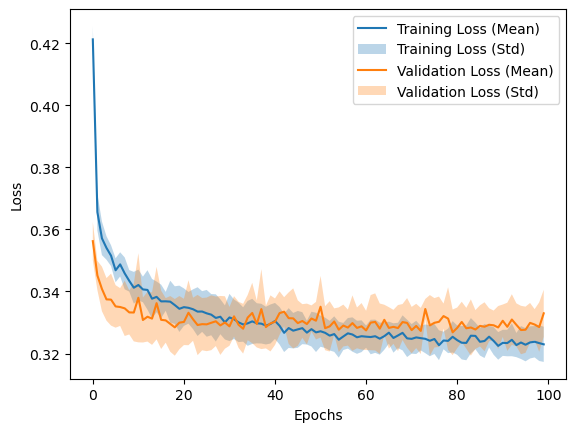

In [23]:
plot_losses(history_list)

Plot the confusion matrix and F1-score

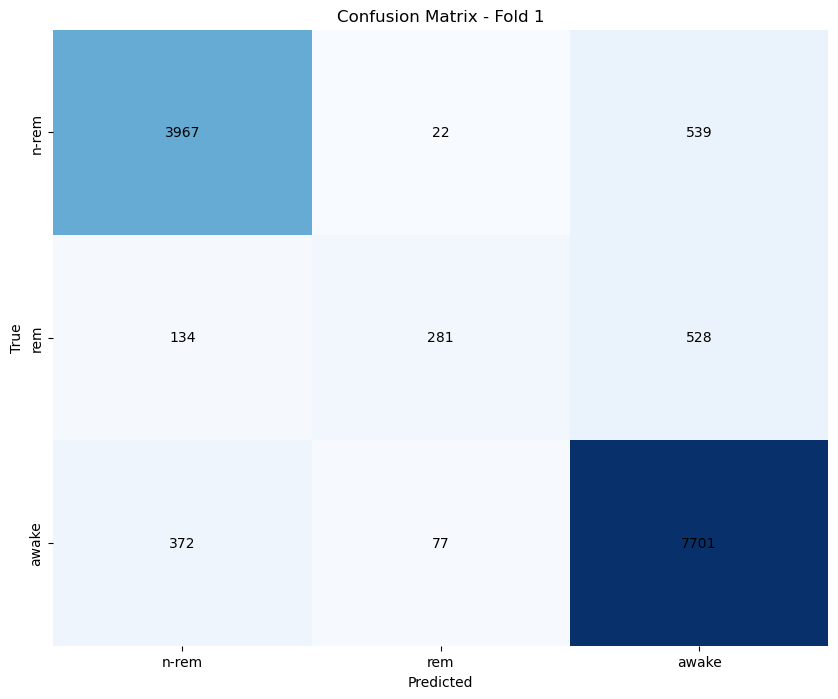

F1 Score - Fold 1: 0.738880351368754


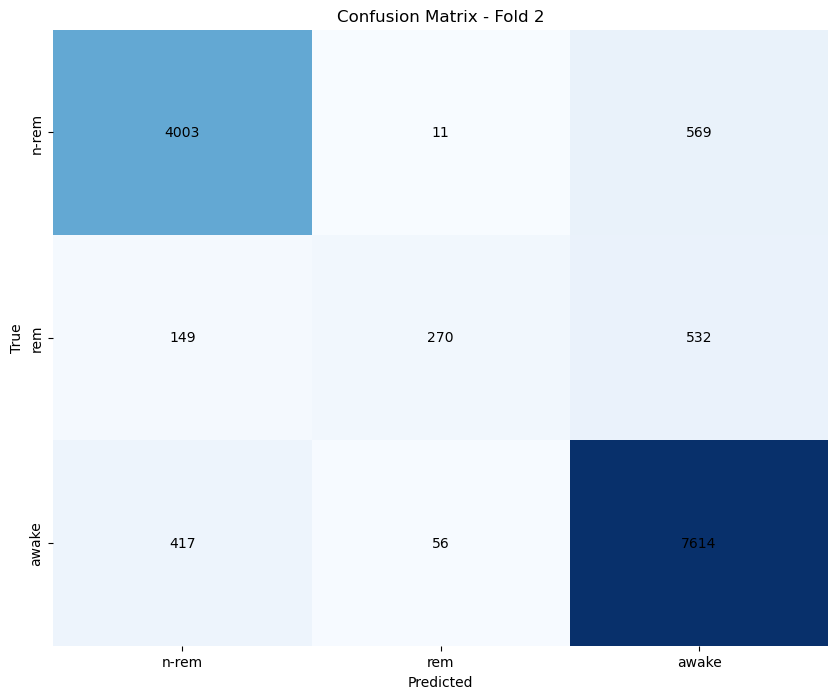

F1 Score - Fold 2: 0.7334522676755162


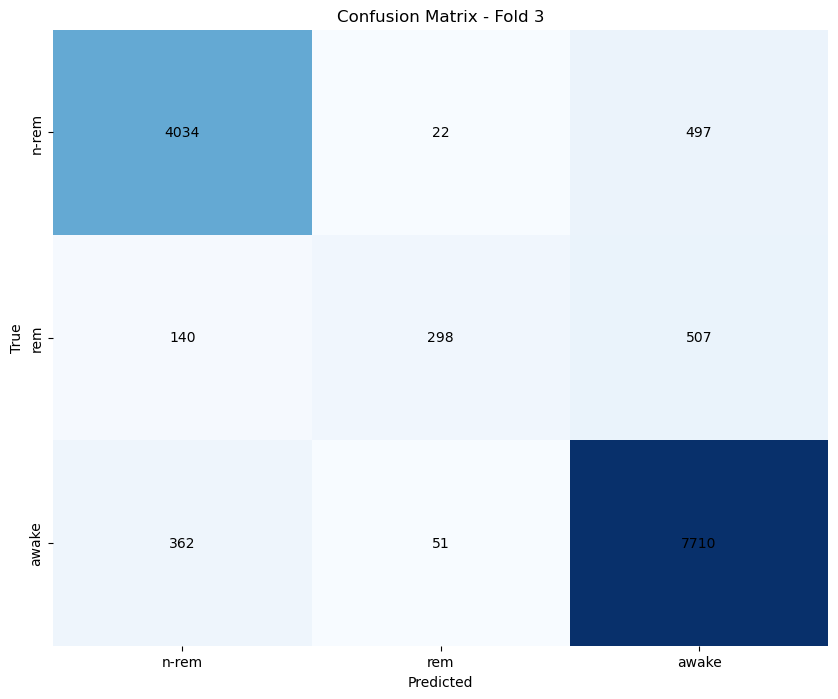

F1 Score - Fold 3: 0.7521313539915254


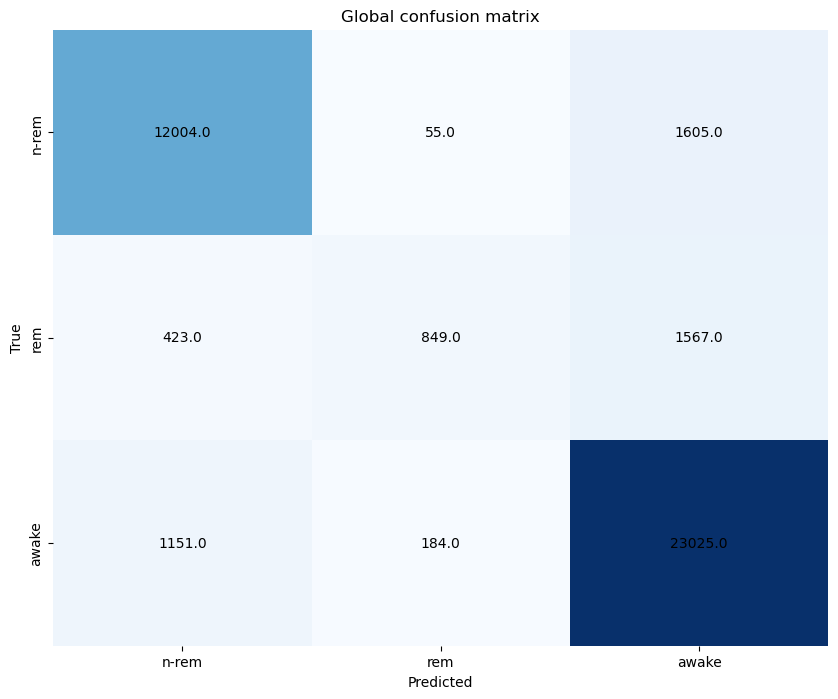

Mean F1 Score across all folds: 0.7414879910119319


In [20]:
f1_scores = []
mean_confusion_matrix = np.zeros((3, 3))


for i, (train_index, test_index) in enumerate(kf.split(input_data)):
    test_data = normalize_data(input_data[train_index], input_data[test_index])
    cm, f1 = test_model(trained_mlp[i], test_data, labels_oneshot[test_index])
    
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')
    mean_confusion_matrix += cm
    
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")
   
    
# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")